## 1 - Project Overview

This customer segmentation project was created in order to solve a marketing problem where promotion campaigns would fall short of expectations. Our campaigns usually consisted of sales of digital analytics courses for marketers, and of membership signups. 

When running a marketing campaign on a large list of customers or email subscribers (i.e. email list with 50,000+ subscribers), it is vital to segment those lists by interests, purchase histories, and behaviors. Without segmentation, marketing campaigns are likely to fail. Without machine learning, segmentation was usually done by guesswork using "ideal customer profiles". 

The challenge is that this approach is very tedious when dealing with an email list of 75k subscribers, or when offering 30+ different products (as is usually the case with a catalog of various training courses). Which was VERY tedious work on an email list with 75,000 subscribers and 30+ different products. We had some some hits and misses with this "manual" method.

This project aims to solve this segmentation challenge using an unsupervised machine learning model that shows how the customer list is "clustered". These clusters can be used to glean insights about each group, and assign segment labels. Subsequently, these labels can then be used to train and test a classification algorithm.

## 2 - Data Analysis

I built this project for my specific use case using a specific dataset downloaded as a .csv file from Kajabi. 

See Kajabi: https://kajabi.com/

This dataset includes customer information, which is scrubbed in the preprocessing phase prior to modeling. Only the following columns are used in the model:

* ID
* Products
* Tags
* Created At
* Sign In Count
* Last Activity
* Last Sign In At

Details about each column is shown in the table below:

<style>
  table {
    max-width: 100%; /* Adjust the width as needed */
  }
  td {
    padding: 8px; /* Adding padding for better readability */
  }
</style>

<table>
    <thead>
        <tr>
            <th>Column</th>
            <th>Data Type</th>
            <th>Description</th>
        </tr>
        <tr>
            <td>ID</td>
            <td>Integer</td>
            <td>Unique user key in lieu of email or any PII</td>
        </tr>
        <tr>
            <td>Products</td>
            <td>String</td>
            <td>Comma-delimited list of products the user has purchased</td>
        </tr>
        <tr>
            <td>Tags</td>
            <td>String</td>
            <td>Comma-delimited list of tags indicating user behaviors and interests</td>
        </tr>
        <tr>
            <td>Created At</td>
            <td>DateTime</td>
            <td>Date when the user account has first been created</td>
        </tr>
        <tr>
            <td>Sign In Count</td>
            <td>Integer</td>
            <td>Total number of time the user has logged into their account</td>
        </tr>
        <tr>
            <td>Last Activity</td>
            <td>Integer</td>
            <td>Date of the last time when the user was active</td>
        </tr>
        <tr>
            <td>Last Sign In At</td>
            <td>Integer</td>
            <td>Date of the last time the user has logged into their account</td>
        </tr>
    </thead>
</table>

*Note: Only Kajabi datasets exported as raw .csv files will work here. Data from other sources than Kajabi will not work properly.*

### 2.1 - Import the data

Assuming a raw .csv file as a full export from Kajabi, the dataset can be imported as follows:

*Warning: This will only work if you have access to the /data/ folder of this project and all the files within. Otherwise, this will result in an error.*

In [ ]:
import pandas as pd

df = pd.read_csv("../data/raw/DDU - Raw Kajabi Data.csv")

### 2.2 - Set aside a test set

Then split the dataset into a training set and a test set, shuffled randomly. Set ```random_state``` to an integer value to ensure reproducibility. 

Note: Although The test set will not be preprocessed in this notebook, all of the same data preprocessing steps described below will also be applied to the test set using scikit-learn's ```Pipeline()```.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

### 2.3 - Clean the data

Prune features we don't need from the dataset (including PII), then show the columns to make sure we have only the columns we need:

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join("../src/")))

from data.make_dataset import prune_dataset
from data.data_cleaning import clean_dataset

df_pruned = prune_dataset(df)
df_pruned.info()

You may have noticed an extra column: 

```"Is_Member"```

The ```prune_dataset()``` function not only removed several columns, but also collapsed multiple columns indicating that the user is a paying member within the ecosystem. 

Next, clean the dataset and impute missing values. For example, ```'Last Activity'``` and ```'Last Sign In At'``` dates will be set equal to the ```'Created At'``` date if the user never logged in since the user's account was created.

Products and Tags also contained missing values in the form of empty strings, so these were replaced with "No Products" and "No Tags", respectively.

In [ ]:
df_cleaned = clean_dataset(df_pruned)
df_cleaned.info()

### 2.4 - Feature engineering

Before continuing, we also need to know how many products and tags each user has. Remember, the ```'Products'``` and ```'Tags'``` are comma-delimited lists of products and tags, respectively. We need to count how many of each a user has, and add those features to the dataset.

In [ ]:
from features.build_features import create_additional_features

df_filtered = create_additional_features(df_cleaned)
df_filtered.info()

During the same feature engineering process above, any rows with zero products and zero tags were dropped from the table as these users have no useful information to use in the model. 

This is why the ```df_filtered``` table has slightly less rows than the ```df_cleaned``` table.

### 2.4 - Exploratory Analysis

Using a custom plotting class, create some historgram plots to see the distribution of the number of products and tags across the user dataset.


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

ax1.hist(df_filtered['Product_Count'], 
        bins=range(1, df_filtered['Product_Count'].max() + 2),
        color="blue"
        )
ax1.set_title("Product Count Histogram")
ax1.set_xlabel("Number of Products")
ax1.set_ylabel("Number of Customers With X Number of Products")

ax2.hist(df_filtered['Tags_Count'], 
        bins=range(1, df_filtered['Tags_Count'].max() + 2),
        color="orange"
        )
ax2.set_title("Tag Count Histogram")
ax2.set_xlabel("Number of Tags")
ax2.set_ylabel("Number of Customers With X Number of Tags")

plt.show()

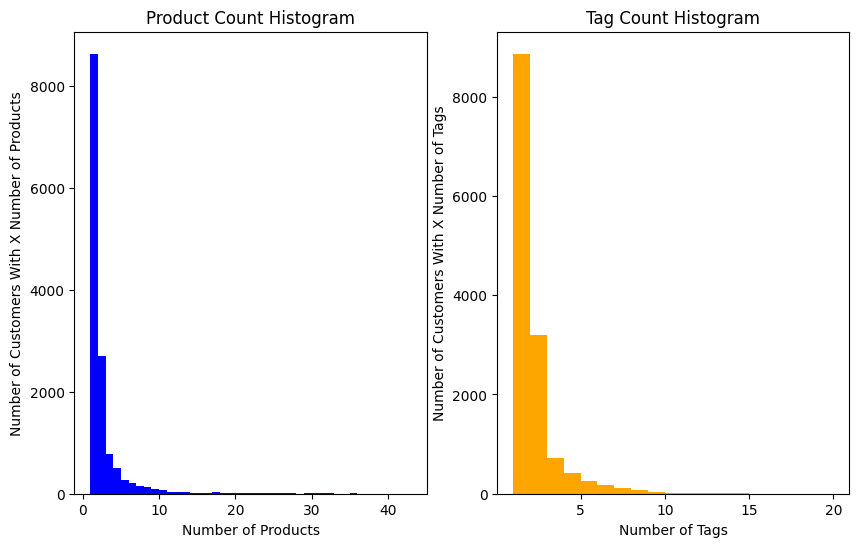

Since the product counts and tag counts are heavily skewed, these features will need to be normalized before training any model. 

For now, continue exploring other features, including how many times each customer has logged into their accounts. It will be interesting to break down and compare sign-in counts among members vs. non-members as well.

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

# All Users
ax1.hist(df_filtered['Sign In Count'], 
        bins=df_filtered['Sign In Count'].max(),
        color="blue"
        )
ax1.set_title("All Users")
ax1.set_xlabel("Number of Sign-ins")
ax1.set_ylabel("Total Number of Customers")

# Members only
members = df_filtered[df_filtered["Is_Member"] == 1]["Sign In Count"]
ax2.hist(members, 
        bins=df_filtered['Sign In Count'].max(),
        color="green"
        )
ax2.set_title("Members Only")
ax2.set_xlabel("Number of Sign-ins")
ax2.set_ylabel("Total Number of Customers")

# Non-members
non_members = df_filtered[df_filtered["Is_Member"] == 0]["Sign In Count"]
ax3.hist(non_members, 
        bins=df_filtered['Sign In Count'].max(),
        color="orange"
        )
ax3.set_title("Non-Members")
ax3.set_xlabel("Number of Sign-ins")
ax3.set_ylabel("Total Number of Customers")

plt.show()

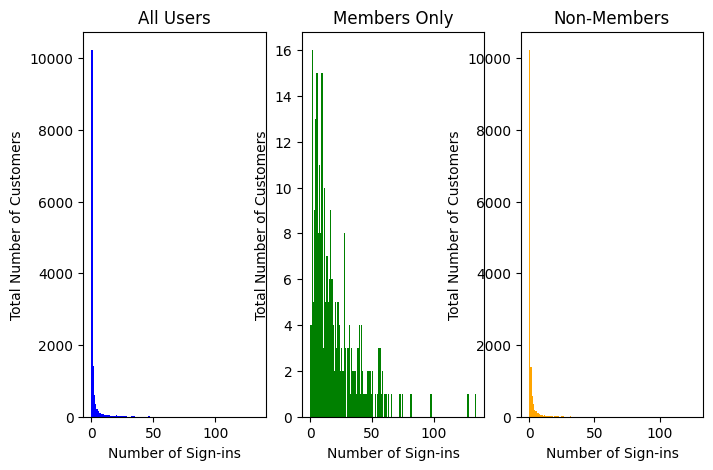

While it's interesting (and not surprising) that members have a much higher number of sign-ins than non-members do, the high number of zero values for sign-ins will present a challenge for model training and testing. 

Unfortunately, this feature may need to be omitted if most of the data needs to be preserved. The alternative will require dropping huge portions of the dataset if filtering out users who have never logged in after account creation. 

In the end, I chose to preserve most of the data and exclude sign-in counts from feature selection.

### 2.5 - Feature scaling

Given extremely skewed distributions in the above data, these features will need to be scaled and transformed before training a ML model.

I started with the RobustScaler() to see if it sufficiently normalizes the distributions.


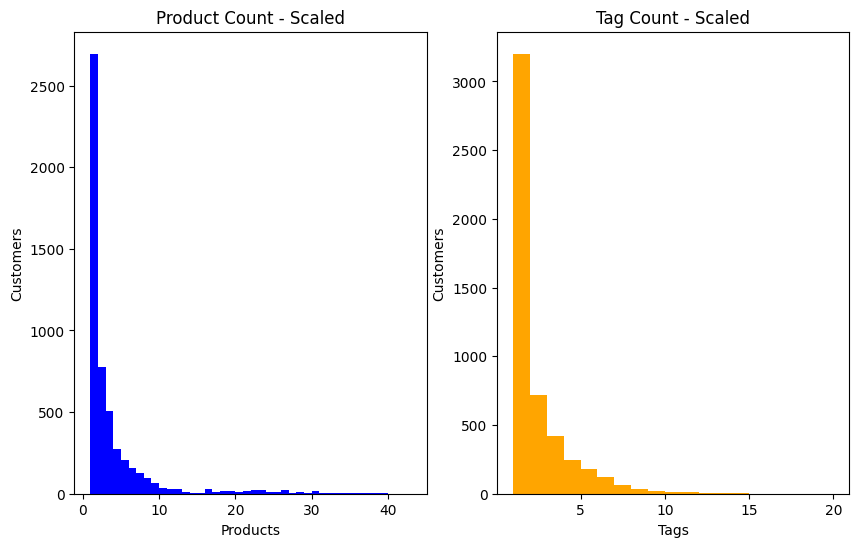

In [77]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df_scaled = df_filtered.copy()
df_scaled = scaler.fit_transform(df_filtered[["Product_Count", "Tags_Count"]])
df_scaled = pd.DataFrame(df_scaled, columns=["Product_Count", "Tags_Count"])

# Check if the scaling adequately normalized the data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

ax1.hist(df_scaled['Product_Count'], 
        bins=range(1, df_filtered['Product_Count'].max() + 2),
        color="blue"
        )
ax1.set_title("Product Count - Scaled")
ax1.set_xlabel("Products")
ax1.set_ylabel("Customers")

ax2.hist(df_scaled['Tags_Count'], 
        bins=range(1, df_filtered['Tags_Count'].max() + 2),
        color="orange"
        )
ax2.set_title("Tag Count - Scaled")
ax2.set_xlabel("Tags")
ax2.set_ylabel("Customers")

plt.show()


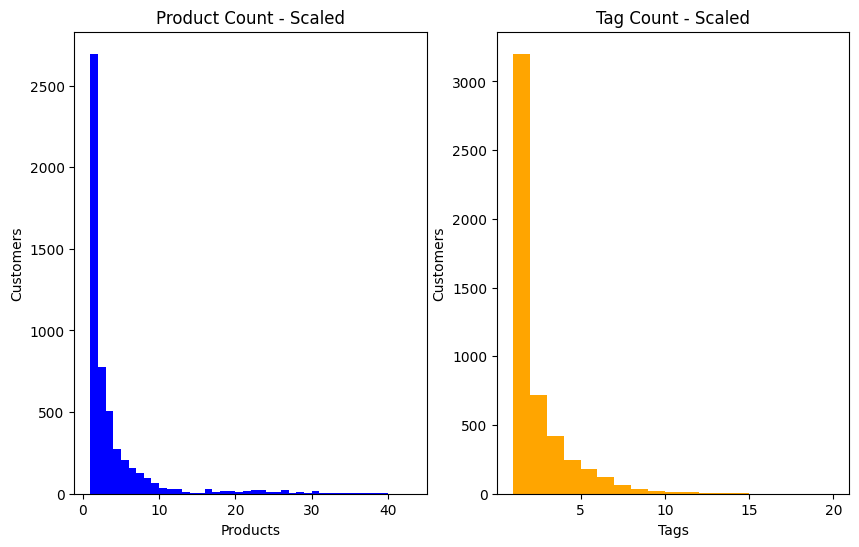

Better than unscaled as you can see in the y-axis, but the distribution is still not normal. 

Next, I will try logarithmic transformation to see if I can get a more normal distribution.

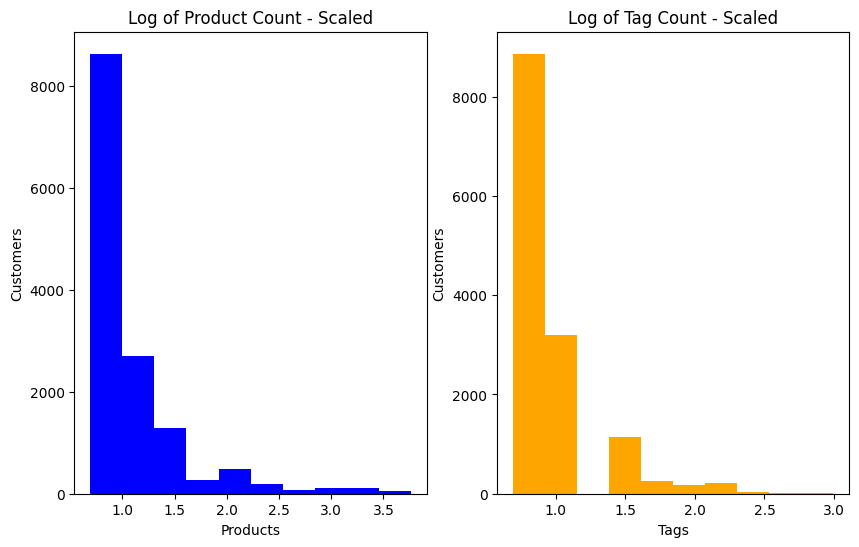

In [81]:
# Use the same scaler as declared above, but start with a fresh copy of the original unscaled but filtered dataframe
import numpy as np

# This time, start by log-transforming these features before applying the scaler
df_transformed = df_filtered.copy()
df_transformed["Log_Product_Count"] = np.log1p(df_transformed["Product_Count"])
df_transformed["Log_Tags_Count"] = np.log1p(df_transformed["Tags_Count"])

scaled_features = scaler.fit_transform(df_transformed[["Log_Product_Count", "Log_Tags_Count"]])
df_scaled = pd.DataFrame(scaled_features, columns=["Log_Product_Count", "Log_Tags_Count"])

# Check if the scaling adequately normalized the data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

ax1.hist(df_transformed['Log_Product_Count'], 
        color="blue"
        )
ax1.set_title("Log of Product Count - Scaled")
ax1.set_xlabel("Products")
ax1.set_ylabel("Customers")

ax2.hist(df_transformed['Log_Tags_Count'], 
        color="orange"
        )
ax2.set_title("Log of Tag Count - Scaled")
ax2.set_xlabel("Tags")
ax2.set_ylabel("Customers")

plt.show()

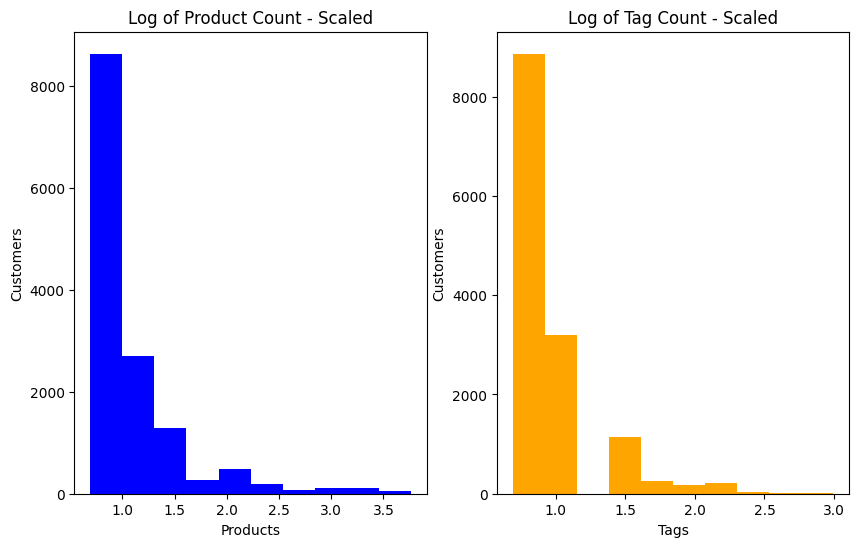

While these distributions aren't normal, they can be interpreted as exponential distributions of similar scales between product and tag counts, as opposed to product counts being double the number of tag counts, unscaled.

While these scaled values can be used in the feature set, there needs to be additional features that provides the model more information than merely how many products or tags each user has. 

### 2.6 - Product encoding

This brings about the next step of one-hot encoding product information under the ```Products``` column. But one-hot encoding will result in a very large and very sparse matrix since there are so many products (over 40 of them). Rather than one-hot encoding alone, I use a CountVectorizer() class to tokenize product names as well. This does both one-hot encoding and tokenization in one step.